In [1]:
import onnxruntime

import torch
from torchvision import transforms
import torch.nn.functional as F

import pandas as pd
import numpy as np

from PIL import Image, ImageFont, ImageDraw

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ort_session = onnxruntime.InferenceSession('ensemble_fruit44.onnx')

In [3]:
font = ImageFont.truetype('arial.ttf', 32)

In [4]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [5]:
idx_to_labels

{0: 'alligator apple',
 1: 'apple',
 2: 'avocado',
 3: 'banana',
 4: 'barberry',
 5: 'bayberry',
 6: 'bell pepper',
 7: 'black berry',
 8: 'black cherry',
 9: 'blueberry',
 10: 'bottle gourd',
 11: 'cantaloupe',
 12: 'carambola',
 13: 'cherry',
 14: 'coconut',
 15: 'corn kernel',
 16: 'custard apple',
 17: 'dragonfruit',
 18: 'durian',
 19: 'eggplant',
 20: 'fig',
 21: 'grape',
 22: 'jackfruit',
 23: 'jalapeno',
 24: 'kiwi',
 25: 'lemon',
 26: 'lime',
 27: 'longan',
 28: 'macadamia',
 29: 'mango',
 30: 'orange',
 31: 'papaya',
 32: 'pea',
 33: 'peanut',
 34: 'pear',
 35: 'persimmon',
 36: 'pineapple',
 37: 'pomegranate',
 38: 'pumpkin',
 39: 'saguaro',
 40: 'strawberry',
 41: 'tomato',
 42: 'watermelon',
 43: 'zucchini'}

In [6]:
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [57]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

time.sleep(1)

success, img_bgr = cap.read()
    
cap.release()


cv2.destroyAllWindows()

In [58]:
img_bgr.shape

(480, 640, 3)

In [59]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

In [60]:
img_pil = Image.fromarray(img_rgb)

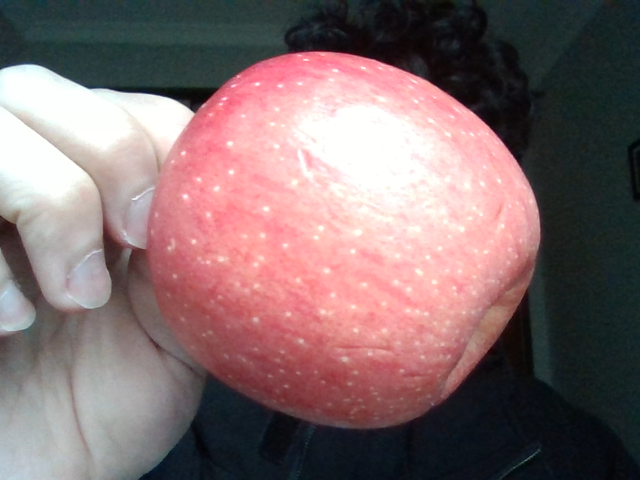

In [61]:
img_pil

In [62]:
input_img = test_transform(img_pil)
input_tensor = input_img.unsqueeze(0).numpy()

In [63]:
ort_inputs = {'input': input_tensor}

pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [64]:
pred_softmax = F.softmax(pred_logits, dim=1)

In [65]:
pred_softmax.shape

torch.Size([1, 44])

In [66]:
n = 5
top_n = torch.topk(pred_softmax, n)
pred_ids = top_n[1].cpu().detach().numpy().squeeze()
confs = top_n[0].cpu().detach().numpy().squeeze() 

In [67]:
draw = ImageDraw.Draw(img_pil) 

for i in range(len(confs)):
    pred_class = idx_to_labels[pred_ids[i]]
    text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
img = np.array(img_pil)

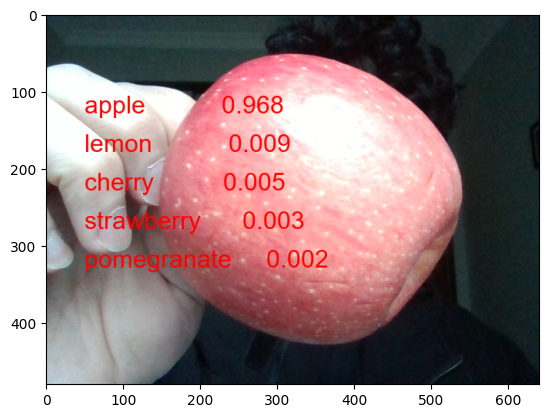

In [68]:
plt.imshow(img)
plt.show()

In [7]:
def process_frame(img):

    start_time = time.time()
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb) 

    input_img = test_transform(img_pil)
    input_tensor = input_img.unsqueeze(0).numpy()
    
    ort_inputs = {'input': input_tensor}
    pred_logits = ort_session.run(['output'], ort_inputs)[0] 
    pred_logits = torch.tensor(pred_logits)
    pred_softmax = F.softmax(pred_logits, dim=1) 

    n = 5
    top_n = torch.topk(pred_softmax, n)
    pred_ids = top_n[1].cpu().detach().numpy().squeeze()
    confs = top_n[0].cpu().detach().numpy().squeeze() 

    draw = ImageDraw.Draw(img_pil) 
    for i in range(len(confs)):
        pred_class = idx_to_labels[pred_ids[i]]
        text = '{:<15} {:>.3f}'.format(pred_class, confs[i])
    
        draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))
    img = np.array(img_pil) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    end_time = time.time()

    FPS = 1/(end_time - start_time)  

    img = cv2.putText(img, 'FPS  '+str(int(FPS)), (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 255), 4, cv2.LINE_AA)
    return img

In [8]:
import cv2
import time

cap = cv2.VideoCapture(1)

cap.open(0)

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print('Error')
        break
    
    frame = process_frame(frame)
    
    cv2.imshow('my_window',frame)

    if cv2.waitKey(1) in [ord('q'),27]:
        break
    
cap.release()

cv2.destroyAllWindows()

In [69]:
import cv2
import numpy as np
import time
from tqdm import tqdm


def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('Video Start Processing',input_path)
    
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('The total number of video frames is',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print('wrong！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('brake')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('save the video', output_path)

In [71]:
generate_video(input_path='test_img/fruits_video.mp4')

Video Start Processing test_img/fruits_video.mp4
The total number of video frames is 212


100%|████████████████████████████████████████████████████████████████████████████████| 211/211 [00:31<00:00,  6.66it/s]

save the video out-fruits_video.mp4
